# Neilyst Demo

本demo将会基于最简单的单symbol的双均线策略，给出一些Neilyst函数的使用实例。本框架现在已经支持多symbol的回测，但是目前部分功能还在优化中，会在全部优化完以后统一再给出一个多symbol的Demo。

**注意**: 本Demo的环境是新建了一个Workspace，在这个folder中clone了Neilyst，这样可以像其他的正常的Python包一样导入，平时我自己开发策略也是这样做的，可以说这样的用法是我开发这个框架的初衷。所以后续的更新也将会按照这个方向优化。

In [1]:
# 导入包
import Neilyst

# 获取数据部分
# 确定回测起止日期和symbol, 时间格式目前必须写成这样
start_time = '2023-01-01T00:00:00Z'
end_time = '2023-12-31T00:00:00Z'
symbol = 'BTC/USDT'

# 获取数据
data = Neilyst.get_klines(symbol, start_time, end_time, timeframe='1h')

# get_kline所有支持的参数如下：symbol=None, start=None, end=None, timeframe='1h', auth=True, retry_count=3, pause=0.001, exchange_name='binanceusdm', proxy='http://127.0.0.1:7890/'

# 每个参数的具体含义可以去这个函数下查看
# 所有数据会保存在data目录中，并且按symbol, 交易所和timeframe分类

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# 指标计算部分

# 这个接口基本上能计算所有的pandas_ta这个库里面支持的所有指标
# 自建指标的功能还在开发中，目前框架并不支持
# 但是get_indicators函数会返回一个带有close价格和各指标结果的dataframe
# 如果有自建指标可以计算完成后拼在后面
indicators = Neilyst.get_indicators(data, 'sma20', 'sma60')
indicators.head()


,close,sma20,sma60
date,,,
2023-01-01 00:00:00+00:00,16527.0,16543.325,16634.703333
2023-01-01 01:00:00+00:00,16550.4,16543.325,16634.703333
2023-01-01 02:00:00+00:00,16542.4,16543.325,16634.703333
2023-01-01 03:00:00+00:00,16529.3,16543.325,16634.703333
2023-01-01 04:00:00+00:00,16517.8,16543.325,16634.703333


In [4]:
# 策略class，一定要继承Neilyst.Strategy
class DoubleMa(Neilyst.Strategy):
    def __init__(self, total_balance, trading_fee_ratio, slippage_ratio, data=None, indicators=None):
        super().__init__(total_balance, trading_fee_ratio, slippage_ratio, data, indicators)
        self.total_balance = total_balance
        self.data = data
        self.indicators = indicators
    
    def run(self, date, price_row, current_pos, current_balance, symbol):
        recent_data = self.get_recent_data(date, 10, self.data, self.indicators, symbol)  # 获取最近10条k线数据和指标数据
        signal = None

        if len(recent_data) >= 3:
            # 获取最近的指标值
            # 为了能跟实盘对应上，这里最新的一条k线默认是取-2
            current_ma20 = recent_data.iloc[-2]['sma20']
            current_ma60 = recent_data.iloc[-2]['sma60']

            # 因此，前一条均线就是取的-3
            prev_ma20 = recent_data.iloc[-3]['sma20']
            prev_ma60 = recent_data.iloc[-3]['sma60']
            
            if current_pos.amount > 0:
                # 此时有仓位，考虑平仓过程
                # current_pos是一个class，具体的结构在model里面可以看到
                # current_pos.dir是当前有的仓位的方向
                # current_pos.amount这个属性表示的是当前仓位的数量
                if current_pos.dir == 'long':
                    if current_ma20 < current_ma60:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                elif current_pos.dir == 'short':
                    if current_ma20 > current_ma60:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                # 这里的signal是返回的下单信号，三个参数分别是下单方向，下单价格，下单量
                # 本框架会一直调用1min数据用来模拟ticker数据，price_row['close']指的就是当前分钟的收盘价
                # 这样滑点会比直接使用data里面的close小一些，更加贴近实盘
            else:
                # 没有仓位，考虑开仓信号
                # 这里的total_balance是策略运行时输入的初始余额
                # 如果每次都用它来计算pos值就相当于每单都以固定的数额下单
                # 如果想测试滚仓效果可以使用current_balance这个变量
                # 这个变量表示当前所剩全部余额
                pos = abs(self.total_balance / price_row['close'])
                if current_ma20 > current_ma60 and prev_ma20 < prev_ma60:
                        signal = Neilyst.Signal('long', price_row['close'], pos)
                if current_ma20 < current_ma60 and prev_ma20 > prev_ma60:
                        signal = Neilyst.Signal('short', price_row['close'], pos)
        
        # 最终返回一个signla
        # 没有信号就返回None
        return signal
    
    def pos_management(self, current_balance):
        # 这里是仓位管理函数
        # 可以按需求计算仓位
        pass


In [5]:
# 策略运行参数
init_balance = 200
strategy = DoubleMa(init_balance, 0.005, 0.01, data, indicators)
result = Neilyst.backtest(symbol, start_time, end_time, strategy)
evaluation = Neilyst.evaluate_strategy(result, init_balance)
# 策略分析结果
evaluation

100%|██████████| 524160/524160 [09:28<00:00, 922.11it/s] 


{'total_pnl': 83.00623267267383,
 'win_rate': 0.3387096774193548,
 'profit_loss_ratio': 2.404964838220807,
 'max_drawdown': 84.34798815757114,
 'annual_return': 0.42773517242671444,
 'sharpe_ratio': 1.034801367464294}

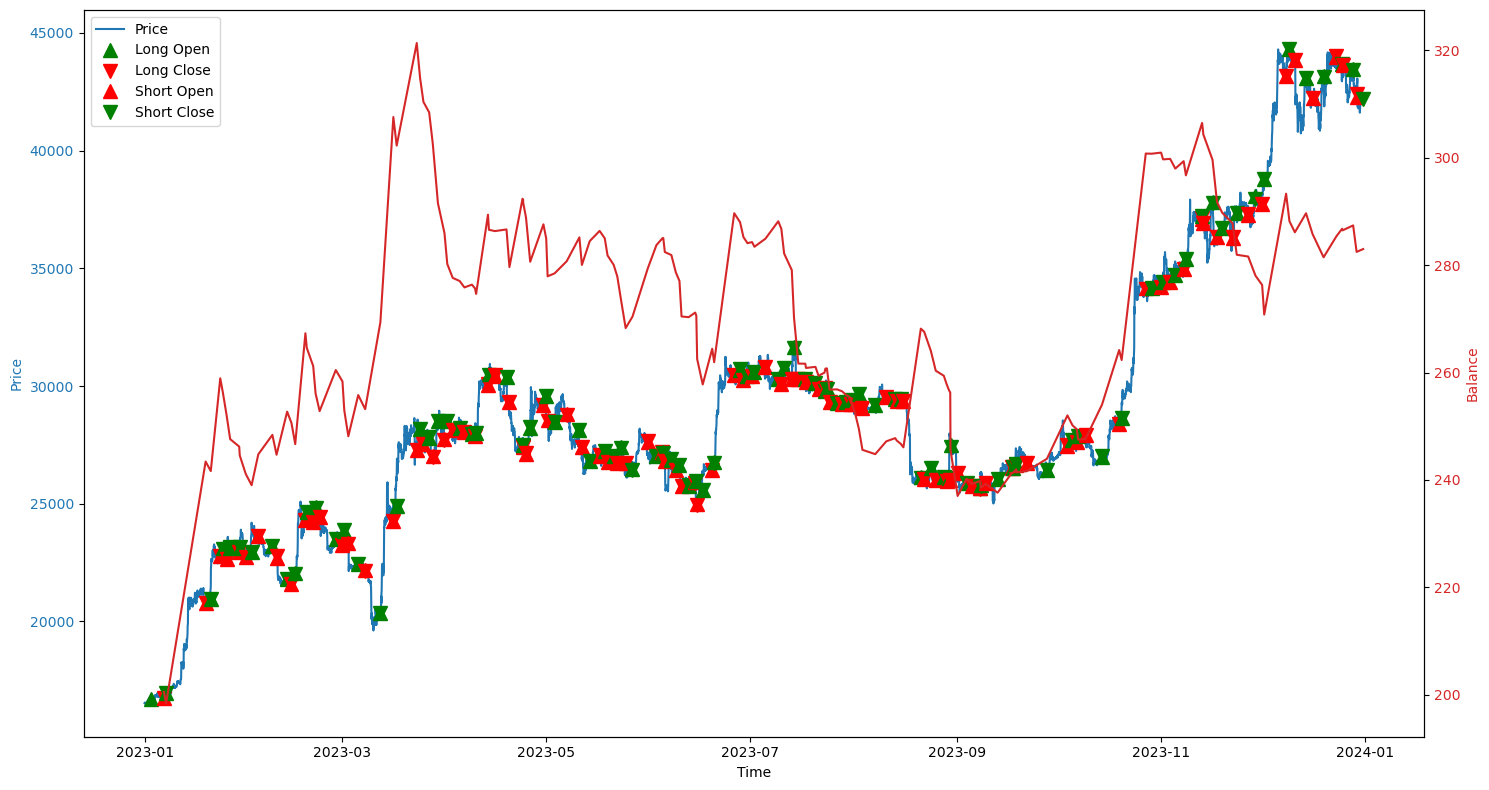

In [6]:
# 可以用这个函数可视化回测结果
Neilyst.show_pnl(data, result, init_balance)